### Visualización de datos litológicos con Python y matplotlib

Añadir información litológica a un gráfico de curva de pozo puede mejorar la interpretación petrofísica o geológica. Permite comprender por qué algunas respuestas de registro se comportan de cierta manera. Estos datos pueden provenir de una interpretación mineralógica previa o de registros de lodo.
El primer paso es incorporar las librerias con las que trabajaremos en este artículo. Usaremos solo dos: pandas y matplotlib. Esto nos permitirá cargar nuestros datos en un dataframe y mostrarlos en un gráfico.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

Los datos se pueden cargar usando pd.read_csv(). Dado que se trata de un conjunto de datos bastante grande, usaremos un solo pozo para trabajar con él y también tomaremos solo las curvas (columnas) que necesitemos. Podemos hacerlo tomando un subconjunto de los datos como se muestra a continuación.

In [2]:
# Cargar los datos (nos aseguramos que la ruta sea correcta para el entorno)
try:
    alldata = pd.read_csv(r'C:\Users\Usuario\Archivos_LAS\xeek_train_subset.csv')
    data = alldata.loc[alldata['WELL'] == '16/10-2'][['DEPTH_MD', 'GR', 'RHOB', 'NPHI', 'FORCE_2020_LITHOFACIES_LITHOLOGY']].copy()
    data.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY':'LITHOLOGY'}, inplace=True)
except FileNotFoundError:
    print("WARNING: 'xeek_train_subset.csv' not found. Using dummy data for demonstration.")
    depth = np.linspace(1000, 2500, 100) # Ajustamos dummy data al rango de interés
    data = pd.DataFrame({
        'DEPTH_MD': depth,
        'GR': np.sin(depth/50) * 50 + 100 + np.random.normal(0, 5, len(depth)),
        'RHOB': np.sin(depth/70) * 0.1 + 2.5 + np.random.normal(0, 0.01, len(depth)),
        'NPHI': np.cos(depth/60) * 0.05 + 0.2 + np.random.normal(0, 0.005, len(depth)),
        'LITHOLOGY': np.random.choice([30000, 65030, 65000, 70000, 80000], size=len(depth))
    })
    data['GR'] = np.clip(data['GR'], 20, 200) # Nos aseguramos que GR tenga un rango razonable


### Configuración de las litologías mediante un diccionario anidado
Las litologías que aparecen actualmente en la columna de litología contienen una serie de números. Podemos asignarlos a un diccionario anidado donde tenemos el nombre completo de la litología, un número simplificado (si se requiere para la conversión), el estilo de tramado y el color del relleno.

Los colores se basan en el sitio web del Servicio Geológico de Kansas. Sin embargo, los símbolos de tramado son limitados en la configuración predeterminada de matplotlib. En un próximo artículo, explicaré cómo crear tramados y litologías personalizados.

In [3]:
# Define el diccionario lithology_numbers como en tu notebook
lithology_numbers = {30000: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                     65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                     65000: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                     80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                     74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                     70000: {'lith':'Limestone', 'lith_num':6, 'hatch':'-|-', 'color':'#80ffff'},
                     70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                     88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                     86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                     99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                     90000: {'lith':'Coal', 'lith_num':11, 'hatch':'', 'color':'black'},
                     93000: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

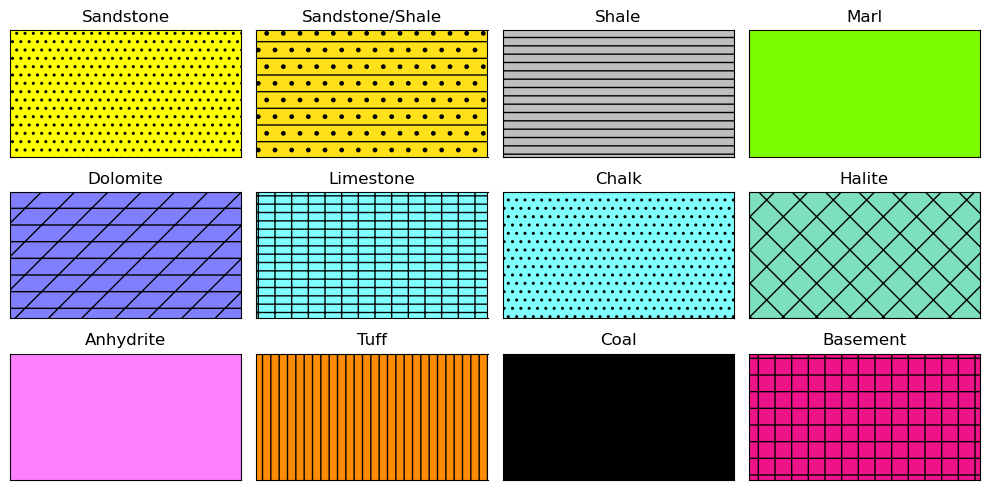

In [4]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()
plt.show()

### Configuración del gráfico de registro de pozo con una pista de litología
Esto nos permite reutilizar fácilmente el código para otros marcos de datos, siempre que los nombres de las curvas sean los mismos. Podríamos refinarlo para hacerlo más genérico. Esta nueva función acepta tres argumentos: el marco de datos, la profundidad superior y la profundidad inferior.

Este código generará un gráfico de registro de pozo con tres pistas: una para rayos gamma, otra que contiene la porosidad de neutrones y la densidad aparente, y la última que contiene nuestros datos de litología geológica.

In [5]:
def make_facies_log_plot(logs, lithology_map_data, depth_min=None, depth_max=None):
    logs = logs.sort_values(by='DEPTH_MD').reset_index(drop=True)

    # Filtrar los datos por el rango de profundidad si se especifica
    if depth_min is not None and depth_max is not None:
        logs = logs[(logs['DEPTH_MD'] >= depth_min) & (logs['DEPTH_MD'] <= depth_max)].copy()
        logs.reset_index(drop=True, inplace=True)
    
    if logs.empty:
        print("No hay datos en el rango de profundidad especificado.")
        return

    # Crear la figura y los ejes (3 tracks)
    fig, axes = plt.subplots(ncols=3, figsize=(10, 12), sharey=True)

    # Invertir el eje Y una vez para todos los subplots
    axes[0].invert_yaxis()
    axes[0].set_ylabel('Depth (MD)')
    
    # Configurar los límites del eje Y para el rango deseado
    axes[0].set_ylim(depth_max, depth_min)

    # --- Track 1: GR ---
    ax1 = axes[0]
    ax1.plot(logs['GR'], logs['DEPTH_MD'], color='green')
    ax1.set_xlabel('GR')
    gr_min_display = logs['GR'].min() # Este es el GR mínimo real en los datos filtrados
    gr_max_display = logs['GR'].max()
    ax1.set_xlim(gr_min_display, gr_max_display)
    ax1.grid(True)
    ax1.set_title('GR Log')


    # --- Track 2: RHOB y NPHI ---
    ax2 = axes[1]
    ax2.plot(logs['RHOB'], logs['DEPTH_MD'], color='red', label='RHOB')
    ax2.set_xlabel('RHOB')
    ax2.set_xlim(logs['RHOB'].min(), logs['RHOB'].max())
    ax2.grid(True)

    ax2b = ax2.twiny()
    ax2b.plot(logs['NPHI'], logs['DEPTH_MD'], color='blue', label='NPHI')
    ax2b.set_xlabel('NPHI')
    ax2b.set_xlim(logs['NPHI'].max(), logs['NPHI'].min())
    ax2b.grid(True)
    ax2.set_title('Density & Neutron')

    # --- Track 3: Litología con la curva GR como "límite" y patrones de relleno ---
    ax3 = axes[2]
    ax3.set_xlabel('Litología')
    ax3.set_xticks([]) # No necesitamos ticks en el eje x para este tipo de plot
    ax3.set_title('Lithology (GR Bounded)')

    # 1. Definir el rango del eje X para el track de litología.
    litho_track_x_min = np.min(logs['GR'])
    if litho_track_x_min > 0:
        litho_track_x_min = 0 
    else:
        litho_track_x_min = np.min(logs['GR']) - 5 

    litho_track_x_max = np.max(logs['GR']) + 50
    if litho_track_x_max < 150:
        litho_track_x_max = 150

    ax3.set_xlim(litho_track_x_min, litho_track_x_max)

    # 2. Iterar sobre los segmentos de litología y dibujar rectángulos con patrones.
    lith_values = logs['LITHOLOGY'].values
    depth_values = logs['DEPTH_MD'].values

    # Find where lithology changes
    change_points = np.where(lith_values[:-1] != lith_values[1:])[0]
    
    # Add start and end points
    # Añadimos un punto inicial y final para cubrir todo el rango de profundidad
    start_indices = np.concatenate(([0], change_points + 1))
    end_indices = np.concatenate((change_points, [len(lith_values) - 1]))

    for i in range(len(start_indices)):
        start_idx = start_indices[i]
        end_idx = end_indices[i]

        current_lithology_code = lith_values[start_idx]
        if current_lithology_code in lithology_map_data:
            color = lithology_map_data[current_lithology_code]['color']
            hatch = lithology_map_data[current_lithology_code]['hatch']
        else:
            color = '#CCCCCC'
            hatch = None

        # Get depths and GR values for this lithology segment
        segment_depths = depth_values[start_idx : end_idx + 1]
        segment_gr_values = logs['GR'].iloc[start_idx : end_idx + 1].values

        # Para que la litología siga la curva GR en el lado izquierdo,
        # necesitamos dibujar múltiples pequeños rectángulos o usar un Path.
        # Volver al fill_betweenx para el relleno base de color,
        # y luego usar un segundo fill_betweenx invisible para los hatches.

        # Fill the area with the solid color first (using fill_betweenx)
        ax3.fill_betweenx(
            segment_depths,
            segment_gr_values, # x1: La curva GR
            litho_track_x_max, # x2: El límite derecho del track
            facecolor=color,
            edgecolor='none',
            linewidth=0,
            zorder=1 # Detrás de la línea GR y el hatch
        )

        # Then, draw the hatch using a second fill_betweenx with facecolor='none'
        # and edgecolor as the color for the hatch lines.
        # Setting a small alpha to hatch lines can make them less overpowering
        if hatch:
            ax3.fill_betweenx(
                segment_depths,
                segment_gr_values,
                litho_track_x_max,
                facecolor='none', # No color fill
                edgecolor='black', # Color de las líneas del hatch (puedes cambiarlo)
                hatch=hatch,
                linewidth=0.5, # Ajustar el grosor de las líneas del hatch
                alpha=0.7, # Transparencia de las líneas del hatch (opcional)
                zorder=2 # Encima del color sólido pero debajo de la línea GR
            )


    # 3. Superponer la curva GR para que sea el límite visible y nítido
    ax3.plot(logs['GR'], logs['DEPTH_MD'], color='green', linewidth=1.5, label='GR', zorder=5) # zorder para que esté encima
    
    ax3.grid(True) # Opcional: añadir cuadrícula al track de litología


    # Crear la leyenda para los colores de litología y patrones
    legend_elements = []
    unique_lithologies_present = logs['LITHOLOGY'].unique()
    
    # Asegúrate de que las litologías se ordenen por lith_num para la leyenda
    sorted_lith_codes = sorted(unique_lithologies_present, key=lambda k: lithology_map_data.get(k, {}).get('lith_num', 999))

    for lith_code in sorted_lith_codes:
        if lith_code in lithology_map_data:
            lith_name = lithology_map_data[lith_code]['lith']
            color = lithology_map_data[lith_code]['color']
            hatch = lithology_map_data[lith_code]['hatch']
            legend_elements.append(Patch(facecolor=color, hatch=hatch, label=lith_name)) # Añade hatch a la leyenda

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


    plt.tight_layout()
    plt.show()

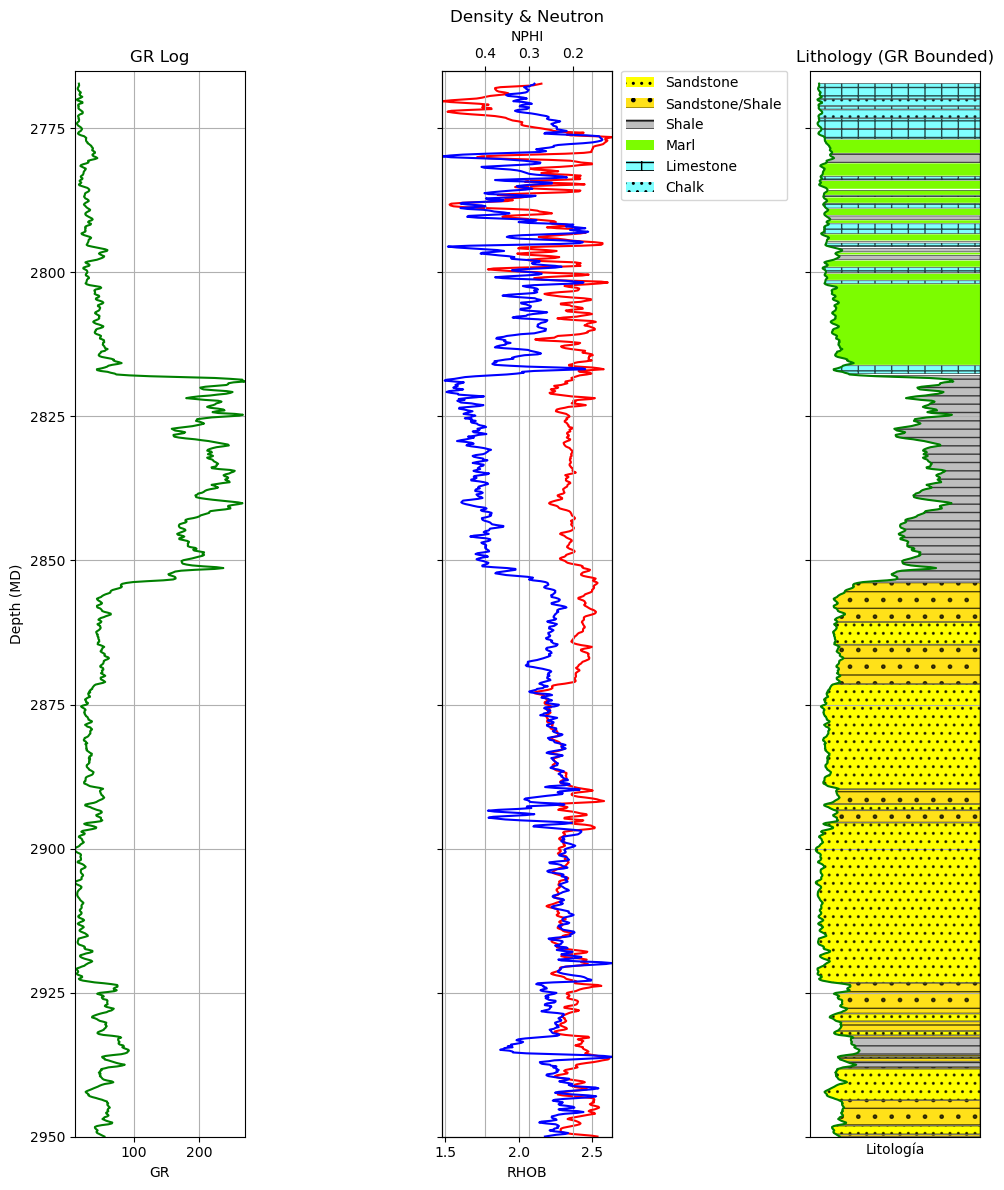

In [8]:
# --- Llamada a la función con el rango de profundidad deseado ---
make_facies_log_plot(data, lithology_numbers, depth_min=2765, depth_max=2950)